In [ ]:
import os
import shutil
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
data_dir = r'C:\Users\menna\Desktop\Last Masked Data\usage'
test_size = 0.2
csv_path = 'filtered_data_updated2.csv'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
import os

def fix_extensions(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.JPG'):
                old_path = os.path.join(root, file)
                new_path = os.path.join(root, file[:-4] + '.jpg')
                os.rename(old_path, new_path)

fix_extensions(r'C:\Users\menna\Desktop\Last Masked Data\usage')


In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    # Wrap the dataloader with tqdm for a progress bar
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
def val_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # Wrap the dataloader with tqdm for a progress bar
    for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=25):
    since = time.time()

    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training phase
            train_loss, train_acc = train_epoch(model, dataloaders['train'], criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc.item())
            print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

            # Validation phase
            val_loss, val_acc = val_epoch(model, dataloaders['val'], criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc.item())
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            # Step the scheduler
            scheduler.step()

            # Save the best model
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    # Plotting the losses and accuracies
    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.resnet152()
model_ft = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

# Replace the classifier with dropout and new linear layer
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(num_ftrs, 3)
)

model_ft = model_ft.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Epoch 0/11
----------


Train Loss: 0.5264 Acc: 0.8413


Val Loss: 0.3136 Acc: 0.8858

Epoch 1/11
----------


Train Loss: 0.2954 Acc: 0.8819


Val Loss: 0.2798 Acc: 0.8918

Epoch 2/11
----------


Train Loss: 0.2577 Acc: 0.8961


Val Loss: 0.2367 Acc: 0.9119

Epoch 3/11
----------


Train Loss: 0.2482 Acc: 0.9034


Val Loss: 0.2329 Acc: 0.9124

Epoch 4/11
----------


Train Loss: 0.2270 Acc: 0.9100


Val Loss: 0.2580 Acc: 0.8992

Epoch 5/11
----------


Train Loss: 0.2170 Acc: 0.9177


Val Loss: 0.2359 Acc: 0.9133

Epoch 6/11
----------


Train Loss: 0.1984 Acc: 0.9217


Val Loss: 0.2617 Acc: 0.9064

Epoch 7/11
----------


Train Loss: 0.1696 Acc: 0.9323


Val Loss: 0.2287 Acc: 0.9204

Epoch 8/11
----------


Train Loss: 0.1608 Acc: 0.9381


Val Loss: 0.2271 Acc: 0.9202

Epoch 9/11
----------


Train Loss: 0.1583 Acc: 0.9375


Val Loss: 0.2318 Acc: 0.9197

Epoch 10/11
----------


Train Loss: 0.1517 Acc: 0.9404


Val Loss: 0.2321 Acc: 0.9216

Epoch 11/11
----------


Train Loss: 0.1552 Acc: 0.9382


Val Loss: 0.2332 Acc: 0.9225

Training complete in 587m 44s
Best val Acc: 0.922509


C:\Users\menna\AppData\Local\Temp\ipykernel_20788\2784520001.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


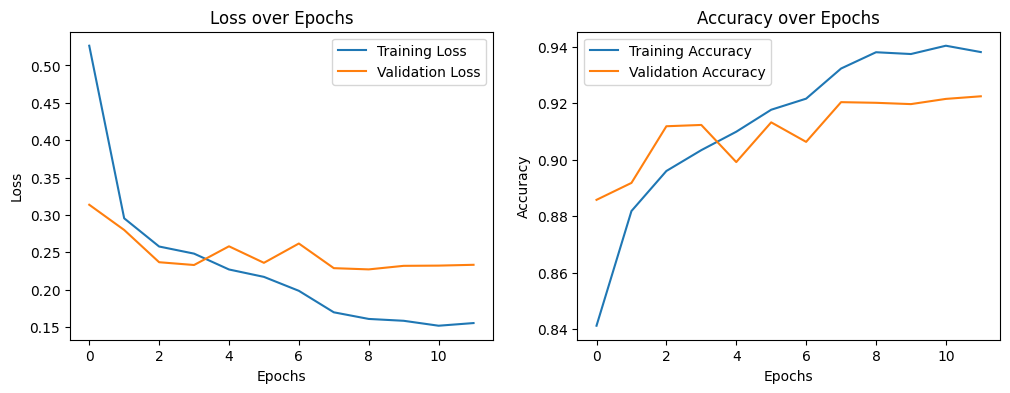

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, device, num_epochs=12)

In [ ]:
torch.save(model_ft.state_dict(), 'usage2.pth')